# 1 - Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import jit, grad, vmap
import qcsys as qs
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt

import jax

cpu_device = jax.devices("cpu")[0]

gpu_device = None
try: 
    gpu_device = jax.devices('gpu')[0] 
except:
    print('No GPU device found.')

No GPU device found.


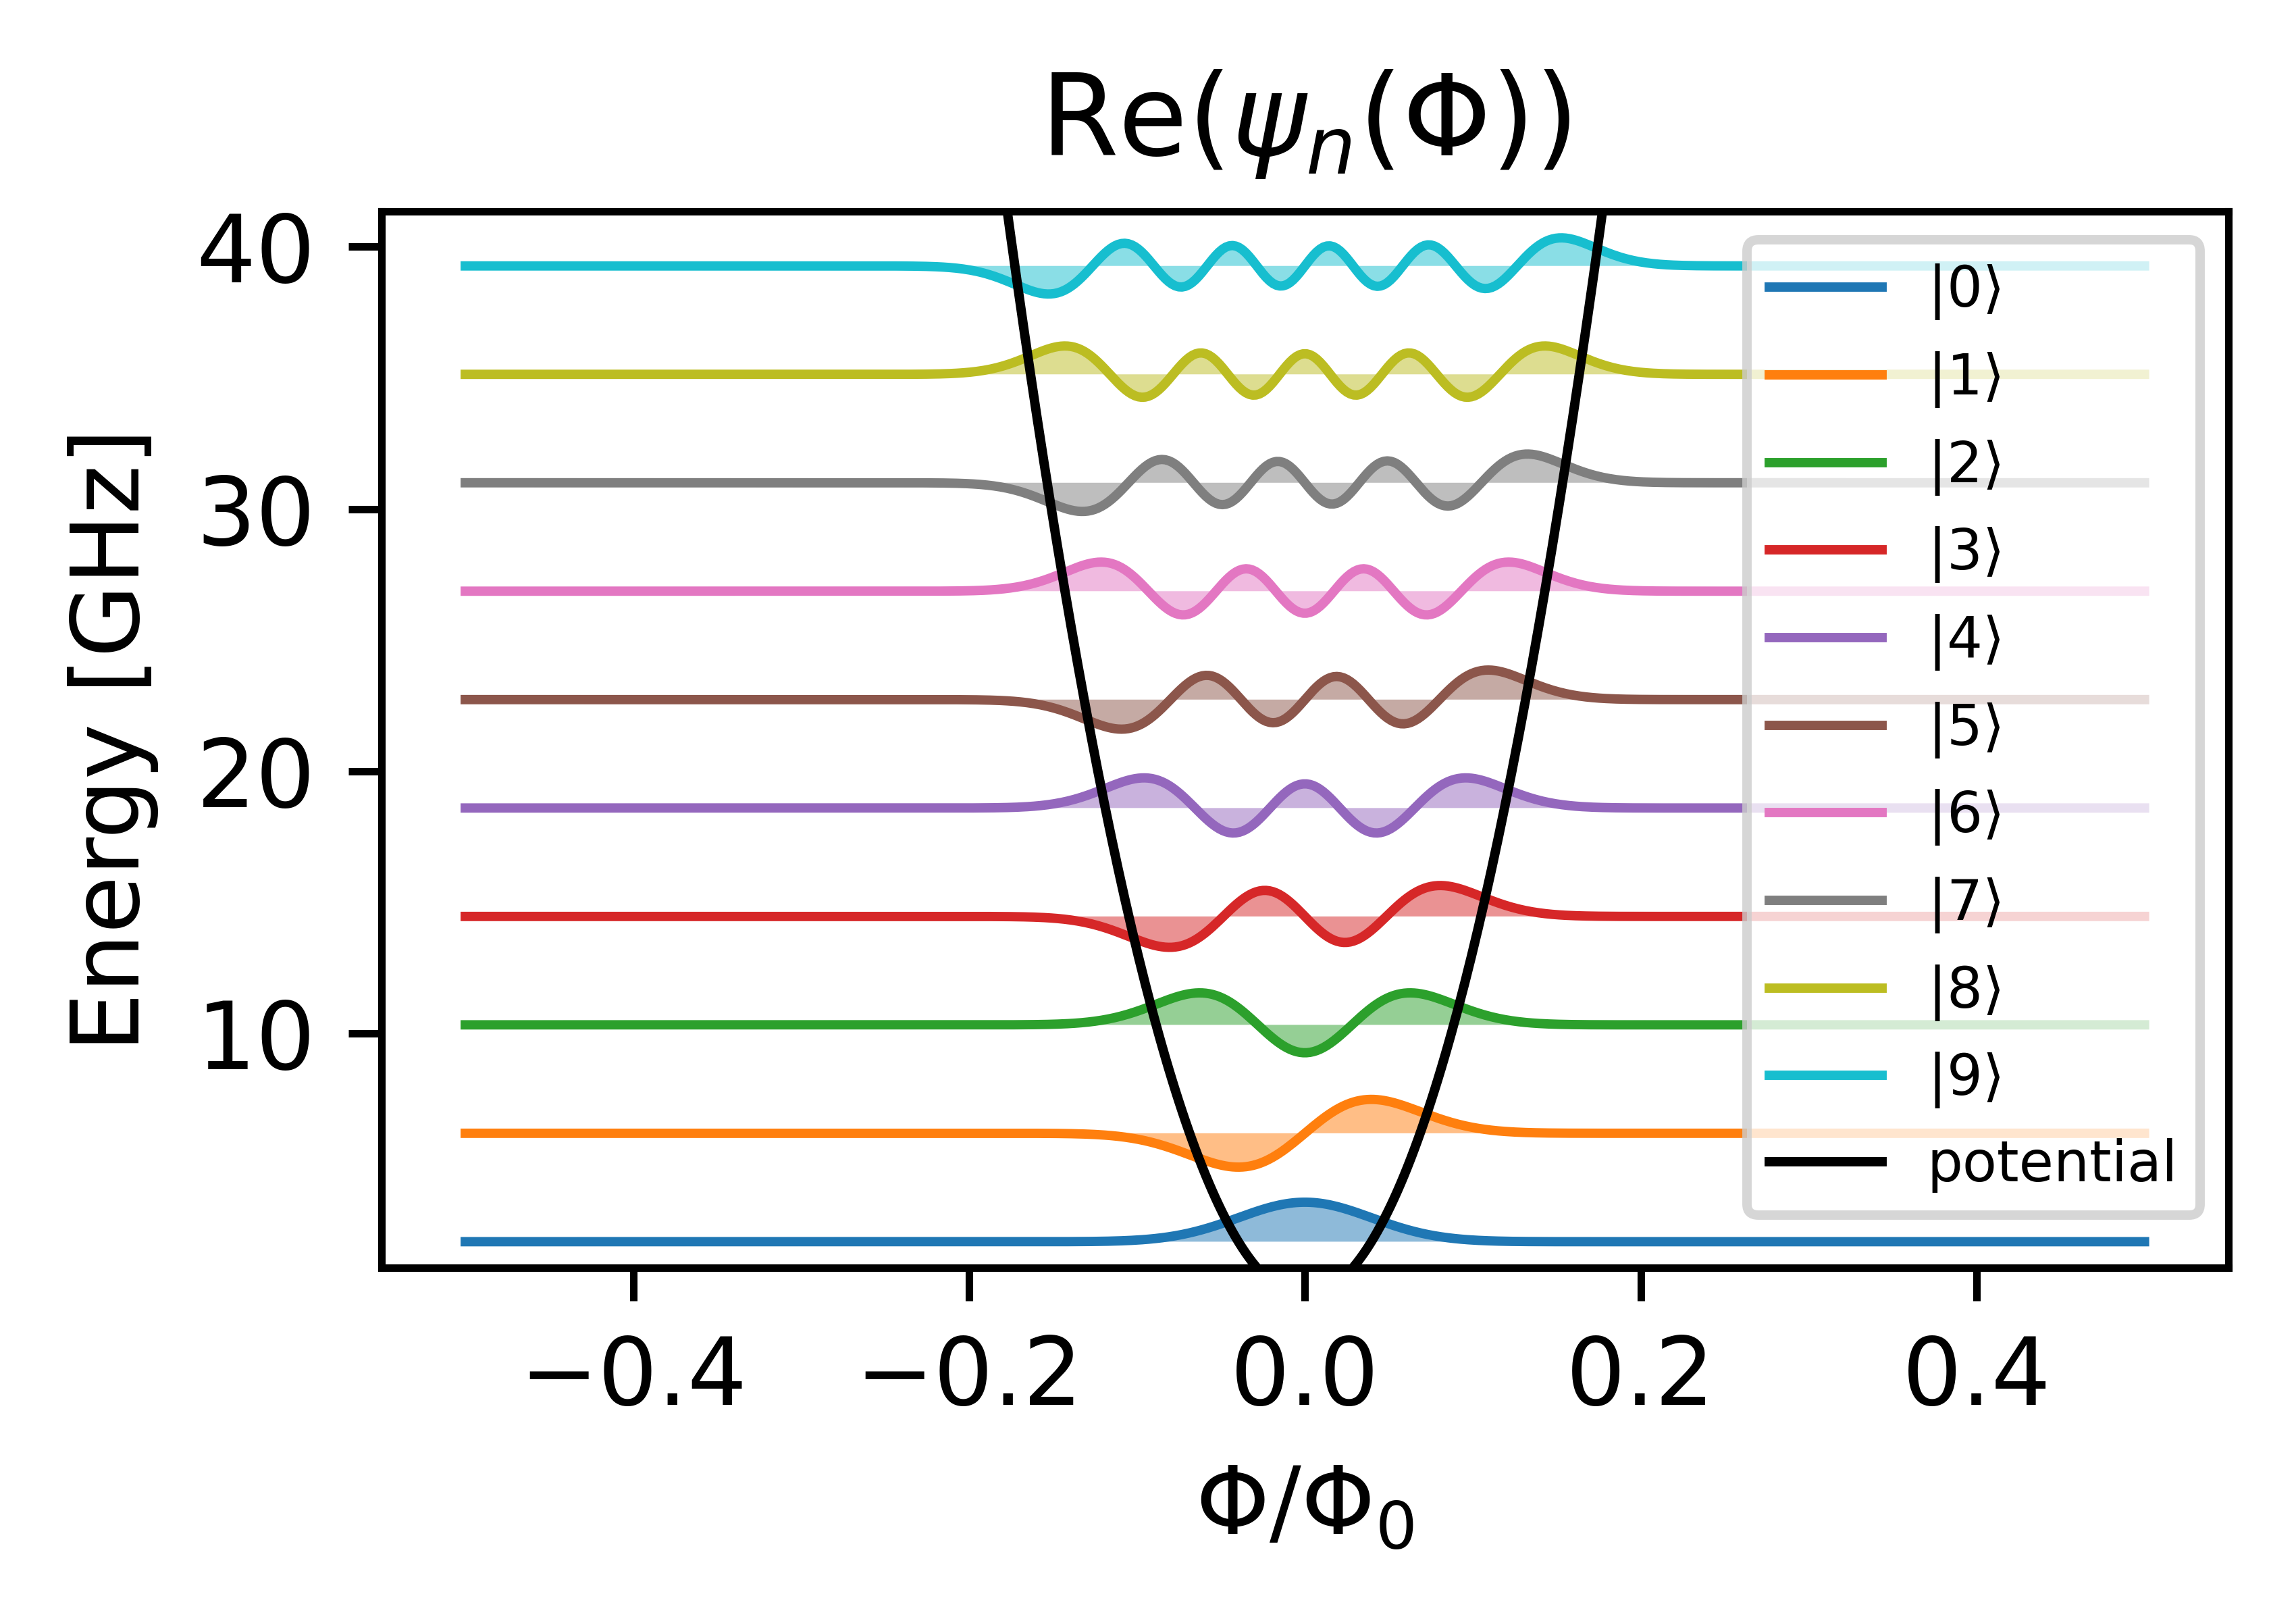

In [3]:
_, Ec_a, El_a = qs.calculate_lambda_over_four_resonator_zpf(4.134, 50)

resonator = qs.Resonator.create(
    10,
    {"Ec": Ec_a, "El": El_a},
    N_pre_diag=10,
)

phi_vals = jnp.linspace(-0.5,0.5,500)
axs = resonator.plot_wavefunctions(phi_vals, mode="real")

In [4]:
Ec_q = 0.844
El_q = 0.300
Ej_q = 3.75
phi_ext = 0.43 

qubit = qs.Fluxonium.create(
    25,
    {"Ec": Ec_q, "El": El_q, "Ej": Ej_q, "phi_ext": phi_ext},
    use_linear=False,
    N_pre_diag=100,
)

Text(0.5, 1.0, '$\\theta_{\\rm ext} = $0.43$\\Phi_0$')

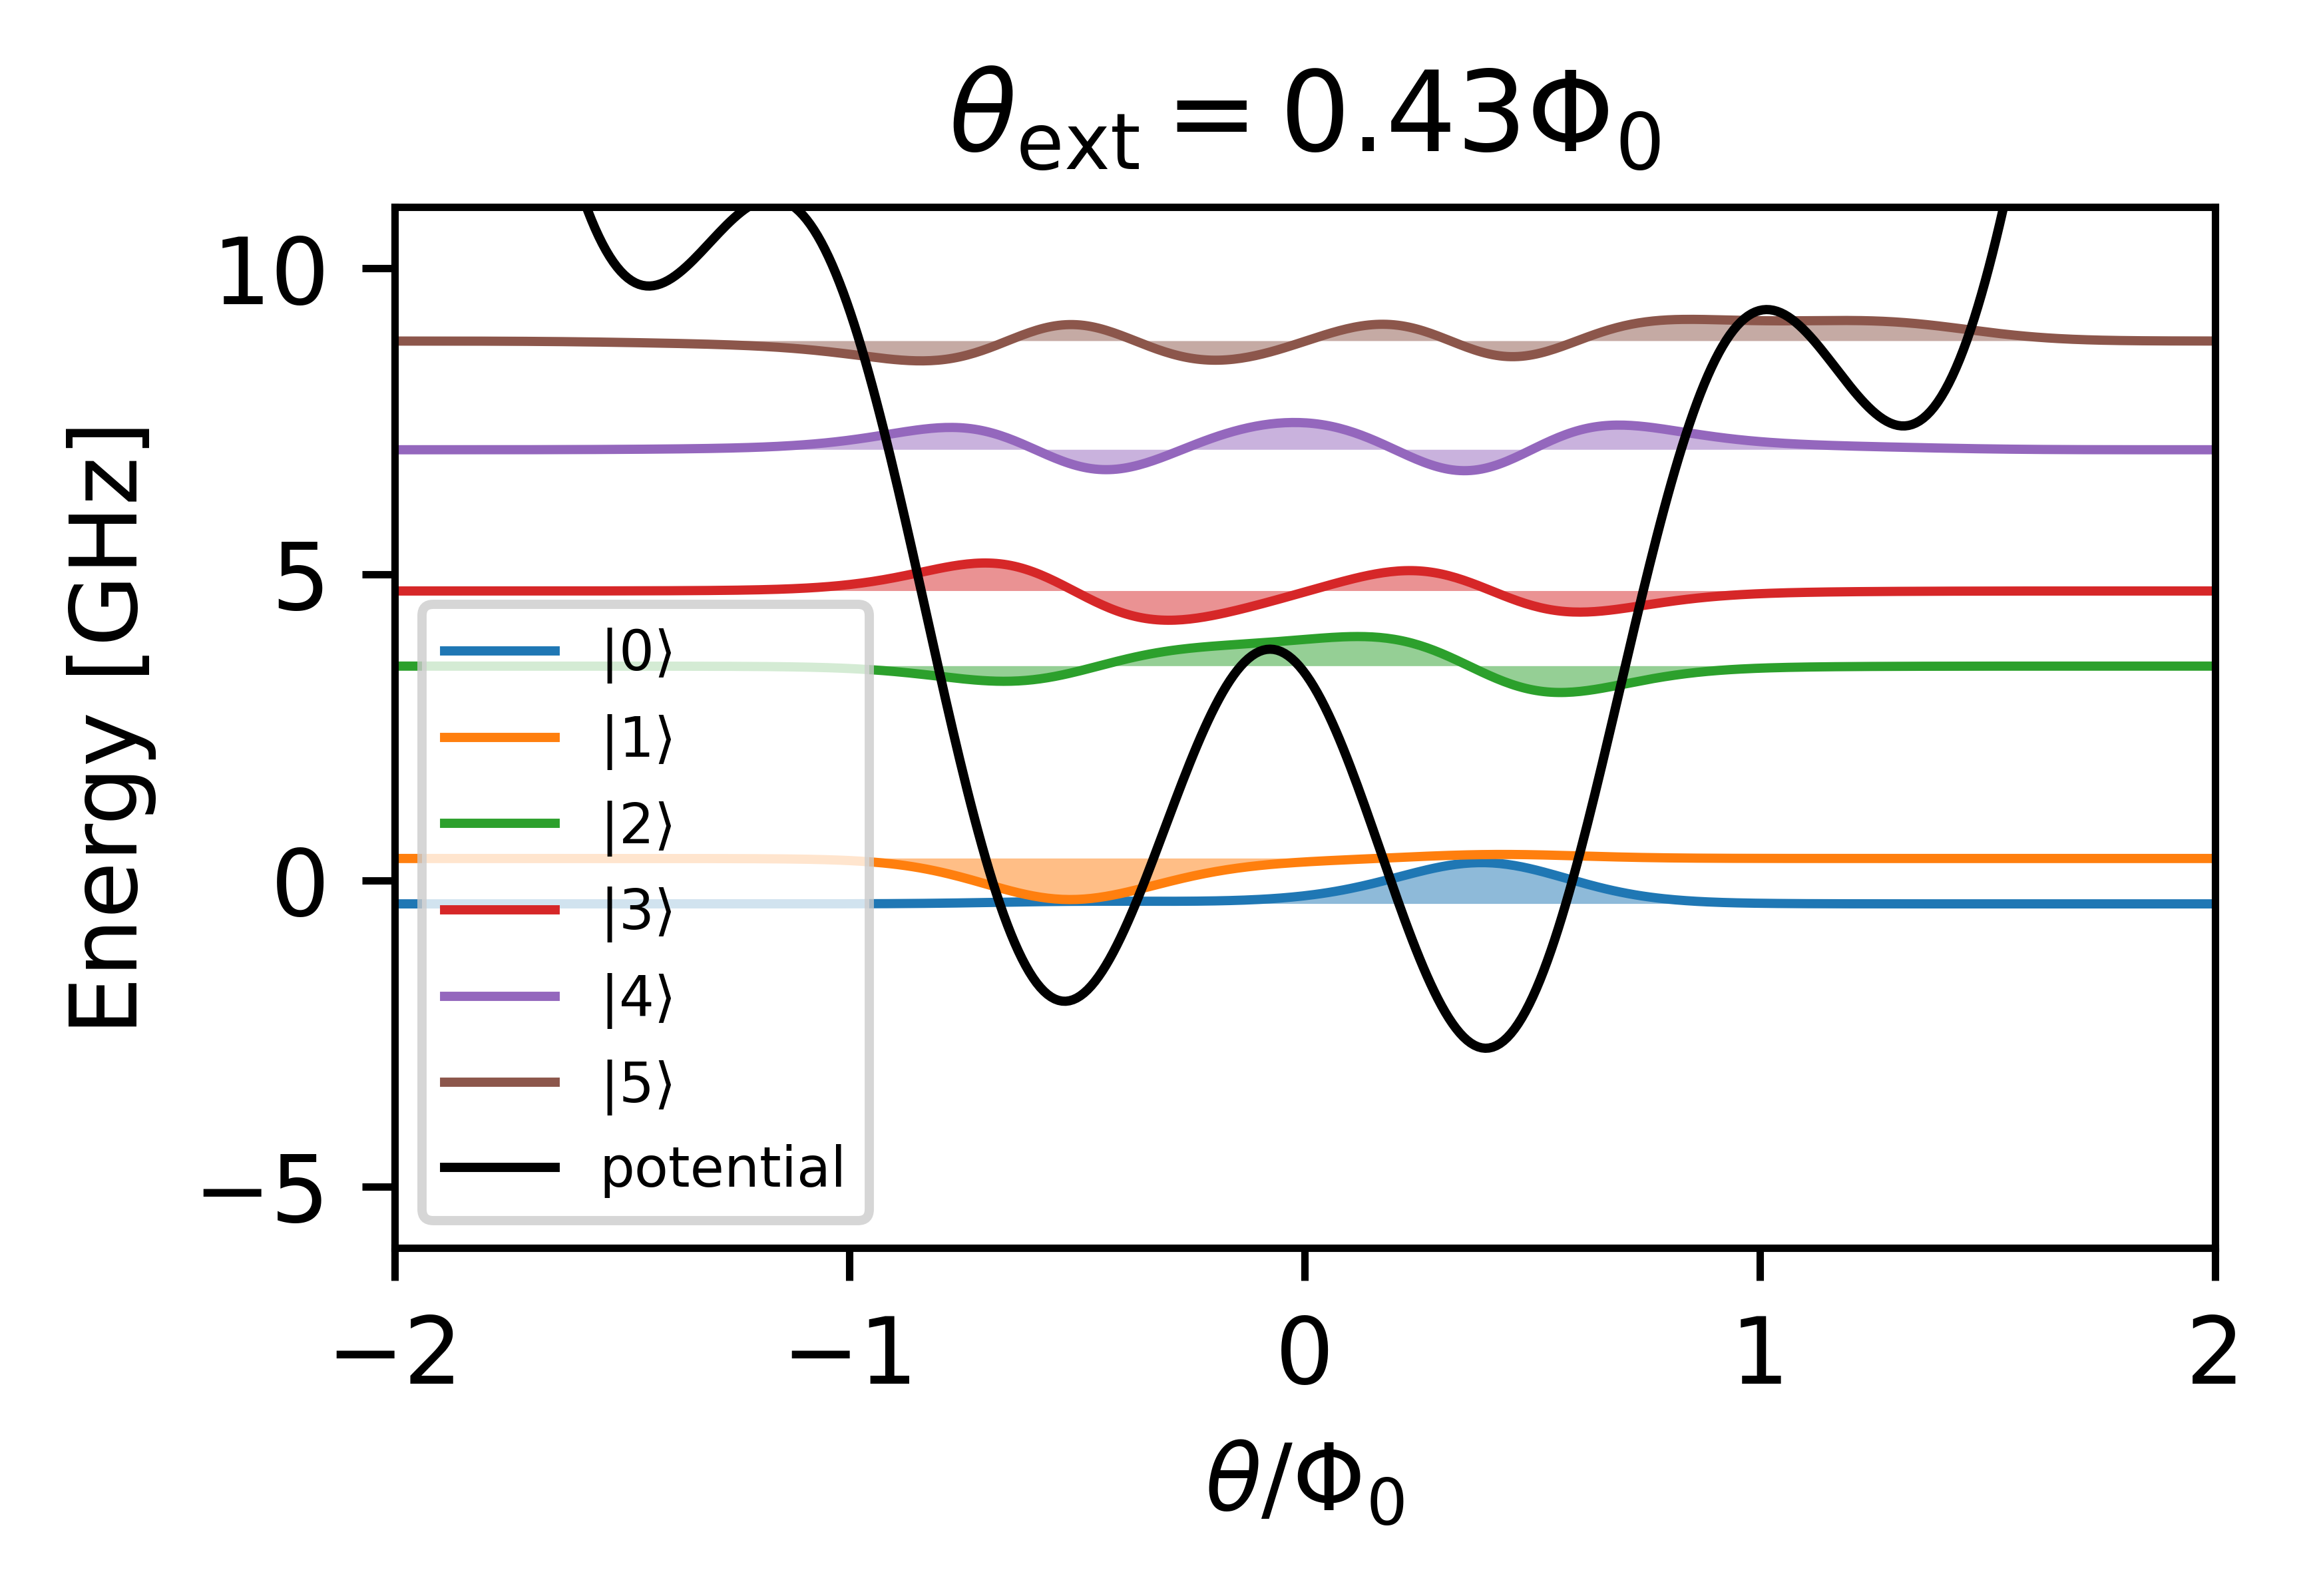

In [5]:
phi_vals = jnp.linspace(-2,2,500)
axs = qubit.plot_wavefunctions(phi_vals, max_n=6, mode="real")
axs.set_ylim(-6,11)
axs.set_xlim(-2,2)
axs.set_xlabel("$\\theta/\\Phi_0$")
axs.set_title("$\\theta_{\\rm ext} = $" + str(phi_ext) + "$\\Phi_0$")

# 3 - System

In [6]:
J_rq = 3e-3


devices = [resonator, qubit]
r_indx = 0
q_indx = 1
Ns = [device.N for device in devices]

n0_q = qs.promote(qubit.ops["n"], q_indx, Ns)
n0_r = qs.promote(resonator.ops["n"], r_indx, Ns)

couplings = []
couplings.append(J_rq * n0_r @ n0_q)

system = qs.System.create(devices, couplings=couplings)

In [7]:
Es, kets = system.calculate_eig()

# chi ----
χ_e = Es[1:, 1] - Es[:-1, 1]
χ_g = Es[1:, 0] - Es[:-1, 0]
χ = χ_e - χ_g

# kerr ----
# kerr[0,n] = (E(n+2, g) - E(n+1, g)) - (E(n+1, g) - E(n, g))
# kerr[1,n] = (E(n+2, e) - E(n+1, e)) - (E(n+1, e) - E(n, e))
K_g = (Es[2:, 0] - Es[1:-1, 0]) - (Es[1:-1, 0] - Es[0:-2, 0])
K_e = (Es[2:, 1] - Es[1:-1, 1]) - (Es[1:-1, 1] - Es[0:-2, 1])

χ, K_g, K_e

(Array([-9.56978670e-05, -9.56310525e-05, -9.55643288e-05, -9.54976956e-05,
        -9.54311528e-05, -9.53647002e-05, -9.52983374e-05, -9.52320630e-05,
        -9.39151600e-05], dtype=float64),
 Array([-3.22874927e-08, -3.22445208e-08, -3.22014362e-08, -3.21585887e-08,
        -3.21157927e-08, -3.20730891e-08, -3.18753415e-08,  2.62573636e-05],      dtype=float64),
 Array([3.45269466e-08, 3.44792426e-08, 3.44316859e-08, 3.43842643e-08,
        3.43368498e-08, 3.42896875e-08, 3.43989868e-08, 2.75742667e-05],      dtype=float64))

# 4 - Sweeps

In [8]:
def create_system(params):
    # Set up Devices 
    # ========================
    # Resonator 
    _, Ec_a, El_a = qs.calculate_lambda_over_four_resonator_zpf(4.134, 50)

    resonator = qs.Resonator.create(
        10,
        {"Ec": Ec_a, "El": El_a},
        N_pre_diag=10,
    )

    Ec_q = 0.844
    El_q = 0.300
    Ej_q = 3.75
    phi_ext = params.get("Fluxonium__external_flux", 0.43) 

    qubit = qs.Fluxonium.create(
        50,
        {"Ec": Ec_q, "El": El_q, "Ej": Ej_q, "phi_ext": phi_ext},
        use_linear=False,
        N_pre_diag=200,
    )
    # ========================

    # Set up system
    # ========================
    J_rq = 3e-3


    devices = [resonator, qubit]
    r_indx = 0
    q_indx = 1
    Ns = [device.N for device in devices]


    n0_q = qs.promote(qubit.ops["n"], q_indx, Ns)
    n0_r = qs.promote(resonator.ops["n"], r_indx, Ns)

    couplings = []
    couplings.append(J_rq * n0_r @ n0_q)
    system = qs.System.create(devices, couplings=couplings)
    # ========================
    
    return system


def calculate_metrics(params):
    system = create_system(params)

    # Metrics
    # ========================
    Es, kets = system.calculate_eig()

    metrics = {}

    # chi ----
    χ_e = Es[1:, 1] - Es[:-1, 1]
    χ_g = Es[1:, 0] - Es[:-1, 0]
    χ = χ_e - χ_g

    # kerr ----
    # kerr[0,n] = (E(n+2, g) - E(n+1, g)) - (E(n+1, g) - E(n, g))
    # kerr[1,n] = (E(n+2, e) - E(n+1, e)) - (E(n+1, e) - E(n, e))
    K_g = (Es[2:, 0] - Es[1:-1, 0]) - (Es[1:-1, 0] - Es[0:-2, 0])
    K_e = (Es[2:, 1] - Es[1:-1, 1]) - (Es[1:-1, 1] - Es[0:-2, 1])

    metrics["χ"] = χ[0]
    metrics["K_avg"] = (K_g[0] + K_e[0])/2
    metrics["K_delta"] = (K_e[0] - K_g[0])/2
    # ========================

    return metrics



In [9]:
# jit allows functions to get faster after the first run
jitted_calculate_metrics = jit(calculate_metrics, device=gpu_device)
%timeit -n1 -r1 jitted_calculate_metrics({"Fluxonium__external_flux": 0.43})
%timeit jitted_calculate_metrics({"Fluxonium__external_flux": 0.43})

3.49 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
416 ms ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
# Sweep option 1: for loop

external_flux_bias_values = jnp.linspace(0.0, 0.51, 511)

start_time = time.time()
for external_flux_bias in external_flux_bias_values:
    jitted_calculate_metrics({"Fluxonium__external_flux": external_flux_bias})
print("Time taken: ", time.time() - start_time)

Time taken:  229.82911086082458


In [11]:
# Sweep option 2: vmap, just make sure you're function is not returning too much data

calculate_metrics_sweep = jit(vmap(calculate_metrics, in_axes=({'Fluxonium__external_flux': 0},)))

external_flux_bias_values = jnp.linspace(0.0, 0.51, 511)

start_time = time.time()
params_sweep = {"Fluxonium__external_flux": external_flux_bias_values}
metrics = calculate_metrics_sweep(params_sweep)
print("Time taken: ", time.time() - start_time)

Time taken:  376.48557472229004


In [12]:
calculate_metrics_sweep_cpu = jit(vmap(calculate_metrics, in_axes=({'Fluxonium__external_flux': 0},)), device=cpu_device)
if gpu_device:
    calculate_metrics_sweep_gpu = jit(vmap(calculate_metrics, in_axes=({'Fluxonium__external_flux': 0},)), device=gpu_device)

In [13]:
external_flux_bias_values = jnp.linspace(0.0, 0.51, 511)
params_sweep = {"Fluxonium__external_flux": external_flux_bias_values}


start_time = time.time()
print(calculate_metrics_sweep_cpu(params_sweep)["χ"].devices())
print("Time taken on CPU: ", time.time() - start_time)

if gpu_device:
    start_time = time.time()
    print(calculate_metrics_sweep_gpu(params_sweep)["χ"].devices())
    print("Time taken on GPU: ", time.time() - start_time)

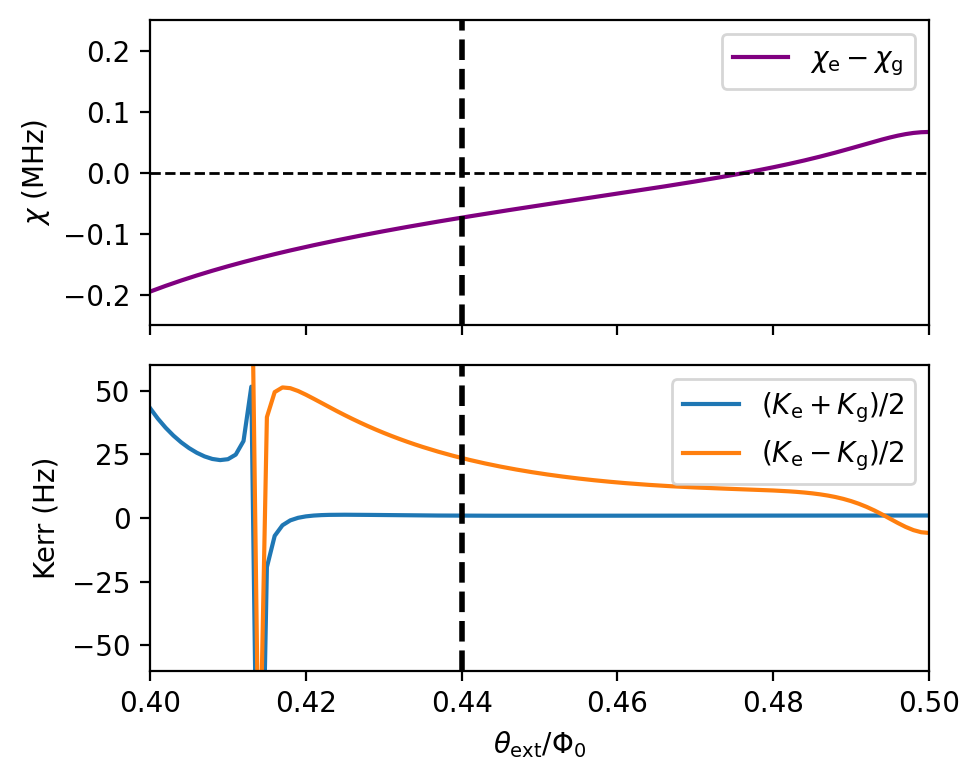

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(5, 4), sharex=True, dpi=200)

chosen_external_bias = 0.44

ax = axs[0]
ax.plot(external_flux_bias_values, metrics["χ"]*1e3, label="$\\chi_{\\rm e} - \\chi_{\\rm g}$", color="purple")
ax.set_ylabel("$\\chi$ (MHz)")
ax.axvline(chosen_external_bias, color="black", linestyle="--", linewidth=2)
ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_xlim(0.4, 0.5)
ax.set_ylim(-.25, .25)
ax.legend()

ax = axs[1]
ax.plot(external_flux_bias_values, metrics["K_avg"]*1e9, label="$(K_{\\rm e} + K_{\\rm g})/2$")
ax.plot(external_flux_bias_values, metrics["K_delta"]*1e9, label="$(K_{\\rm e} - K_{\\rm g})/2$")
ax.set_ylabel("Kerr (Hz)")
ax.set_xlabel("$\\theta_{\\rm ext}/\\Phi_0$")
ax.axvline(chosen_external_bias, color="black", linestyle="--", linewidth=2)
ax.set_xlim(0.4, 0.5)
ax.set_ylim(-60, 60)
ax.legend()

fig.tight_layout()
plt.show()

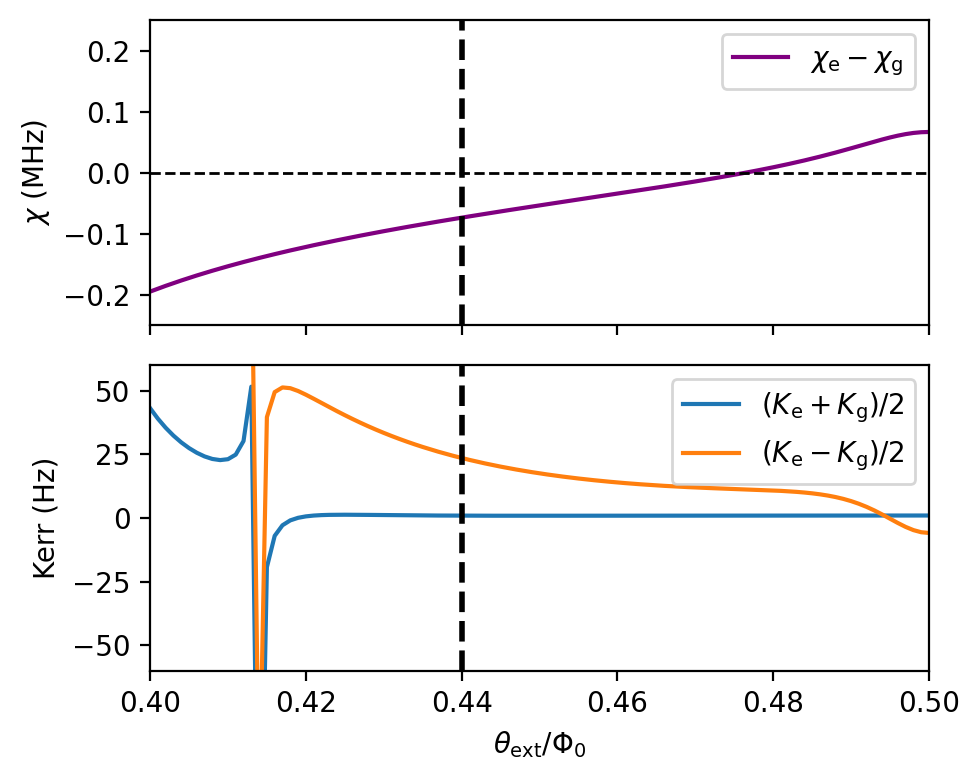

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(5, 4), sharex=True, dpi=200)

chosen_external_bias = 0.44

ax = axs[0]
ax.plot(external_flux_bias_values, metrics["χ"]*1e3, label="$\\chi_{\\rm e} - \\chi_{\\rm g}$", color="purple")
ax.set_ylabel("$\\chi$ (MHz)")
ax.axvline(chosen_external_bias, color="black", linestyle="--", linewidth=2)
ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_xlim(0.4, 0.5)
ax.set_ylim(-.25, .25)
ax.legend()

ax = axs[1]
ax.plot(external_flux_bias_values, metrics["K_avg"]*1e9, label="$(K_{\\rm e} + K_{\\rm g})/2$")
ax.plot(external_flux_bias_values, metrics["K_delta"]*1e9, label="$(K_{\\rm e} - K_{\\rm g})/2$")
ax.set_ylabel("Kerr (Hz)")
ax.set_xlabel("$\\theta_{\\rm ext}/\\Phi_0$")
ax.axvline(chosen_external_bias, color="black", linestyle="--", linewidth=2)
ax.set_xlim(0.4, 0.5)
ax.set_ylim(-60, 60)
ax.legend()

fig.tight_layout()
plt.show()